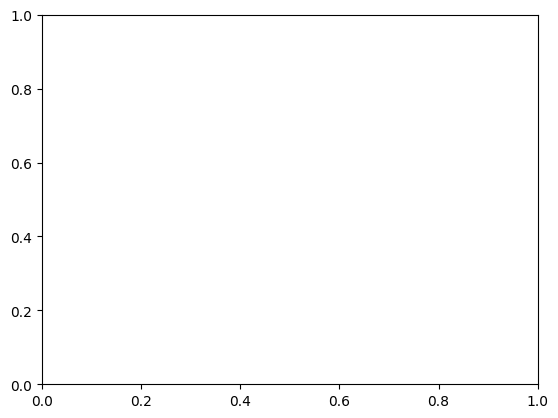

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gymnasium as gym
from gymnasium import spaces
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

In [40]:
EPISODES = 100
MAX_STEPS = 200
COLUMNS = 10
ROWS = 10

In [41]:
class GridEnv(gym.Env):
    def __init__(self):
        super(GridEnv, self).__init__()
        self.action_space = spaces.Discrete(4) # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([ROWS - 1, COLUMNS - 1]), dtype=np.int32)
        self.reward_map = None
        self.obstacle_position = [np.random.randint(ROWS), np.random.randint(COLUMNS)]
        self.step_counter = 0
        self.total_rewards_collected = 0
        self.reset()

    def reset(self):
        self.state_agent1 = np.array([0, 0])  # Starting position for agent 1
        self.state_agent2 = np.array([ROWS - 1, COLUMNS - 1])  # Starting position for agent 2
        self.initialize_reward_map()
        self.step_counter = 0
        self.total_rewards_collected = 0
        return self.state_agent1, self.state_agent2
    
    def initialize_reward_map(self):
        self.reward_map = np.full((ROWS, COLUMNS), 1)
        self.reward_map[self.obstacle_position[0], self.obstacle_position[1]] = -100
        # self.reward_map[self.state[0], self.state[1]] = 100  # Set the starting column to 0
        # self.reward_map[ROWS-1,0] = 100
        # self.reward_map[-1, :] = 100  # Set the bottom row to 100
            
    def reset_reward_map(self):
        self.initialize_reward_map()
        self.reward_map[0,0] = -1  # Mark the starting position


    def step(self, action_agent1, action_agent2):
        # Apply action for agent 1
        new_state_agent1, reward_agent1, done_agent1 = self.apply_action(self.state_agent1, action_agent1)

        # Apply action for agent 2
        new_state_agent2, reward_agent2, done_agent2 = self.apply_action(self.state_agent2, action_agent2)

        # Update states for both agents
        self.state_agent1 = new_state_agent1
        self.state_agent2 = new_state_agent2

        # Update the reward map to reflect movements of both agents
        y1, x1 = self.state_agent1
        y2, x2 = self.state_agent2
        self.reward_map[y1, x1] = -1  # Mark position for agent 1
        self.reward_map[y2, x2] = -1  # Mark position for agent 2

        # Check if either agent is done
        done = done_agent1 or done_agent2

        return (new_state_agent1, new_state_agent2), (reward_agent1, reward_agent2), done, {}
        
    def apply_action(self, state, action):
        # Initialize reward and done flag
        reward = 0.
        done = False

        # Action mappings (no changes here)
        action_mappings = {
            0: (-1, 0),  # Move up
            1: (1, 0),   # Move down
            2: (0, -1),  # Move left
            3: (0, 1)    # Move right
        }

        # Update state based on action
        delta = action_mappings.get(action, (0, 0))
        new_state = np.array([state[0] + delta[0], state[1] + delta[1]])

        # Check and handle boundary conditions
        if new_state[0] < 0 or new_state[0] >= ROWS or new_state[1] < 0 or new_state[1] >= COLUMNS:
            reward = -100
            done = True
        else:
            reward = self.calculate_reward(new_state)
            done = self.is_done()

        return new_state, reward, done
    
    def calculate_reward(self, state):
        # Calculate reward based on the current state
        return self.reward_map[state[0], state[1]]

    def is_done(self):
        # Check if all cells in the grid have been visited or if a step limit is reached
        max_steps = MAX_STEPS
        return np.all(self.reward_map == -1) or self.step_counter >= max_steps
            
    def render(self, mode='human'):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.reward_map, cmap='viridis', origin='lower')

        # Plot Agent 1's position
        plt.scatter(self.state_agent1[1], self.state_agent1[0], c='red', marker='o', label='Agent 1')

        # Plot Agent 2's position
        plt.scatter(self.state_agent2[1], self.state_agent2[0], c='blue', marker='o', label='Agent 2')

        plt.title("Agents' Movement in Grid")
        plt.legend()
        plt.pause(0.1)  # Pause for a short period to create animation effect
        

In [42]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.2, discount_factor=0.9, epsilon=0.1, gasoline_capacity=1000, wheat_capacity=100):
        self.env = env
        self.gasoline = gasoline_capacity  # Initial gasoline level
        self.wheat = 0  # Initial wheat level
        self.gasoline_capacity = gasoline_capacity
        self.wheat_capacity = wheat_capacity

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((ROWS, COLUMNS, env.action_space.n))

    def choose_action(self, state, neg_reward):
        if neg_reward > 3:
            # Implement logic to find the nearest positive reward
            action = self.find_nearest_positive_reward_action(state)
        elif np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()  # Explore: random action
        else:
            state_index = (state[0], state[1])
            action = np.argmax(self.q_table[state_index])  # Exploit: best known action
        return action    
    
    def find_nearest_positive_reward_action(self, state):
        min_distance = float('inf')
        best_action = None

        # Search the grid for the nearest positive reward
        for y in range(ROWS):
            for x in range(COLUMNS):
                if self.env.reward_map[y, x] > 0:  # Check for positive reward
                    distance = abs(state[0] - y) + abs(state[1] - x)
                    if distance < min_distance:
                        min_distance = distance
                        best_action = self.determine_action_to_reward(state, (y, x))

        return best_action

    def determine_action_to_reward(self, current_state, reward_state):
        dy = reward_state[0] - current_state[0]
        dx = reward_state[1] - current_state[1]

        if abs(dy) > abs(dx):
            return 1 if dy > 0 else 0  # Move down (1) or up (0) based on the y-difference
        else:
            return 3 if dx > 0 else 2  # Move right (3) or left (2) based on the x-difference
    
    def learn(self, state, action, reward, next_state):
        state_index = (state[0], state[1])
        next_state_index = (next_state[0], next_state[1])
        # Update rule for Q-learning
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error



In [43]:
def train_agent(env, agent1, agent2, episodes):
    best_total_reward_agent1 = -float('inf')
    best_total_reward_agent2 = -float('inf')
    best_path_agent1 = []
    best_path_agent2 = []

    for episode in range(episodes):
        state_agent1, state_agent2 = env.reset()
        current_path_agent1 = [state_agent1]
        current_path_agent2 = [state_agent2]
        done = False
        total_reward_agent1 = 0
        total_reward_agent2 = 0
        neg_reward_agent1 = 0
        neg_reward_agent2 = 0

        while not done:
            action_agent1 = agent1.choose_action(state_agent1, neg_reward_agent1)
            action_agent2 = agent2.choose_action(state_agent2, neg_reward_agent2)

            (next_state_agent1, next_state_agent2), (reward_agent1, reward_agent2), done, _ = env.step(action_agent1, action_agent2)

            agent1.learn(state_agent1, action_agent1, reward_agent1, next_state_agent1)
            agent2.learn(state_agent2, action_agent2, reward_agent2, next_state_agent2)

            state_agent1, state_agent2 = next_state_agent1, next_state_agent2
            total_reward_agent1 += reward_agent1
            total_reward_agent2 += reward_agent2
            current_path_agent1.append(state_agent1)
            current_path_agent2.append(state_agent2)

            if reward_agent1 < 0:
                neg_reward_agent1 += 1
            else:
                neg_reward_agent1 = 0

            if reward_agent2 < 0:
                neg_reward_agent2 += 1
            else:
                neg_reward_agent2 = 0

        if total_reward_agent1 > best_total_reward_agent1:
            best_total_reward_agent1 = total_reward_agent1
            best_path_agent1 = current_path_agent1

        if total_reward_agent2 > best_total_reward_agent2:
            best_total_reward_agent2 = total_reward_agent2
            best_path_agent2 = current_path_agent2

        if episode % 100 == 0:
            print(f"Episode {episode}: Total Reward Agent 1: {total_reward_agent1}, Agent 2: {total_reward_agent2}")

    return best_path_agent1, best_path_agent2


In [44]:
# Create the environment
env = GridEnv()

# Create two agents
agent1 = QLearningAgent(env)
agent2 = QLearningAgent(env)

# Train the agents
best_path_agent1, best_path_agent2 = train_agent(env, agent1, agent2, episodes=EPISODES)

Episode 0: Total Reward Agent 1: -100, Agent 2: 1


IndexError: index 10 is out of bounds for axis 1 with size 10

In [ ]:
def animation_plot(state_agent1, state_agent2, env, ax):
    # Update the reward map to reflect the agents' movement
    env.reward_map[state_agent1[0], state_agent1[1]] = -1
    env.reward_map[state_agent2[0], state_agent2[1]] = -1

    ax.clear()
    ax.imshow(env.reward_map, cmap=cmap, norm=norm, alpha=0.8)  # Use the custom colormap
    ax.scatter(state_agent1[1], state_agent1[0], color='red', label='Agent 1', s=100)
    ax.scatter(state_agent2[1], state_agent2[0], color='blue', label='Agent 2', s=100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()

    
def update(frame, best_path, env, ax):
    best_path_agent1, best_path_agent2 = best_path
    if frame < len(best_path_agent1):
        state_agent1 = best_path_agent1[frame]
        state_agent2 = best_path_agent2[frame]
        animation_plot(state_agent1, state_agent2, env, ax)
    else:
        update.done = True  # Stop the animation when the end of the best path is reached

colors = ['black', 'green', 'white', 'yellow']  # Replace with actual colors
cmap = mcolors.ListedColormap(colors)

# Define the boundaries for these values
# The values are chosen to ensure that -100, -1, and 1 fall into separate bins
bounds = [-200, -1, 1, 200]
norm = mcolors.BoundaryNorm(bounds, cmap.N)


In [ ]:
# Reset the environment and reward map to initial state
env.reset()
env.reset_reward_map()

# Create the animation using the best path
animation = FuncAnimation(fig, lambda frame: update(frame, (best_path_agent1, best_path_agent2), env, ax), frames=max(len(best_path_agent1), len(best_path_agent2)), interval=100)
# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())


In [ ]:
# def plot_best_path(env, best_path):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(env.reward_map, cmap='viridis', origin='lower')

#     # Plot the path
#     for state in best_path:
#         plt.scatter(state[1], state[0], c='red', marker='o')

#     plt.title("Best Path in Grid")
#     plt.show()
# plot_best_path(env, best_path)
# print(best_path)

In [ ]:
def transform_path(original_path, iteration):
    transformed_path = []
    ROWS = 10  # Assuming the number of rows is constant at 10

    for x, y in original_path:
        if iteration % 2 == 1:
            # For odd iterations, increase x and increment y
            new_x = x
            new_y = y + (iteration - 1)
        else:
            # For even iterations, decrease x and increment y
            new_x = ROWS - 1 - x
            new_y = y + (iteration - 1)
        
        transformed_path.append(np.array([new_x, new_y]))

    # Add the last point of the iteration
    if iteration % 2 == 1:
        transformed_path.append(np.array([ROWS - 1, transformed_path[-1][1] + 1]))
    else:
        transformed_path.append(np.array([0, transformed_path[-1][1] + 1]))

    return transformed_path

for iteration in range(1, 4):
    print(f"Iteration {iteration}: {transform_path(best_path, iteration)}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
# def plot_q_values(agent):
#     fig, axs = plt.subplots(agent.env.grid_size, agent.env.grid_size, figsize=(20, 20))

#     # Iterate over all grid cells
#     for i in range(agent.env.grid_size):
#         for j in range(agent.env.grid_size):
#             ax = axs[i, j]
#             q_values = agent.q_table[i, j]

#             # Use a bar chart or similar to represent Q-values for each action
#             ax.bar(range(len(q_values)), q_values, color=['blue', 'green', 'red', 'purple'])
#             ax.set_ylim([-100, 100])  # Assuming Q-values are in this range; adjust as needed
#             ax.set_xticks(range(len(q_values)))
#             ax.set_xticklabels(['Up', 'Down', 'Left', 'Right'])
#             ax.set_title(f"State ({i}, {j})")

#     plt.tight_layout()
#     plt.show()

# # Assuming your agent is named 'agent' and has been trained
# plot_q_values(agent)